# Imports

In [78]:
import gurobipy
import cvxpy as cp
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from os import path
from tqdm import tqdm

# Function Definitions

Below, we define several functions that we will use throughout the rest of the notebook. Each function is documented with comments.

In [79]:
def prepData(data, features, train=0.8, seed=3230):
    '''
    Preprocess data and split into training and testing sets.
    '''

    # Convert ground truth labels into -1 for cancer and +1 for benign
    data["diagnosis"] = data["diagnosis"].apply(lambda x: 1 if x == "M" else -1)

    # Shuffle data and split into 80% training set and 20% testing set
    dataRandomized = data.sample(frac=1, random_state=seed).reset_index(drop=True)
    nTrain = int(0.8 * len(data))
    train = dataRandomized[:nTrain]
    test = dataRandomized[nTrain:]

    # Normalize the training features and test features using the training feature means and standard deviations
    trainMeasures = train[features]
    testMeasures = test[features]
    trainMeans = trainMeasures.mean()
    trainStds = trainMeasures.std()
    trainMeasuresNorm = (trainMeasures - trainMeans) / trainStds
    testMeasuresNorm = (testMeasures - trainMeans) / trainStds

    # Return normalized training and test sets with ground truth labels
    trainProcessed = pd.concat([trainMeasuresNorm, train["diagnosis"]], axis=1)
    testProcessed = pd.concat([testMeasuresNorm, test["diagnosis"]], axis=1)
    return trainProcessed, testProcessed

In [94]:
def fit(data, misclassificationPenalty=0.25):
    '''
    Fit the SVM using the quadratic program formulation.
    '''

    # n is the number of observations and m is the number of features
    n = len(train)
    m = len(data.columns) - 1

    # Declare decision variables
    w = cp.Variable(m)
    b = cp.Variable(1)
    e = cp.Variable(n)

    # Make a constraint for each observation
    constraints = [
        row["diagnosis"] * ((w.T @ row.iloc[:m].to_numpy()) + b) >= 1 - e[index] for index, row in train.iterrows()
    ]
    # Enforce nonnegativity for each "slack" variable e_i
    constraints.extend([
        e[i] >= 0 for i in range(n)
    ])

    # Define objective function
    obj_func = (cp.norm(w) ** 2) + (misclassificationPenalty * cp.sum(e))

    # Minimize the objective function and return the optimum solution for w and b
    problem = cp.Problem(cp.Minimize(obj_func), constraints)
    problem.solve(solver=cp.GUROBI)
    return w.value, b.value, constraints

In [81]:
def confusionMatrix(test, w, b):
    '''
    Compute a confusion matrix for the test data based on the fit SVM parameters.
    '''

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    m = len(test.columns) - 1

    # Classify each test data point as a true positive, false positive, true negative, or false negative
    for index, row in test.iterrows():
        gt = row["diagnosis"]
        pred = np.sign(row.iloc[:m].to_numpy() @ w + b)
        if gt == 1:
            if pred == 1:
                TP += 1
            else:
                FN += 1
        else:
            if pred == -1:
                TN += 1
            else:
                FP += 1

    # Return the confusion matrix as a DataFrame
    return pd.DataFrame([[TP, FP], 
                         [FN, TN]], 
                        columns=['Predicted Positive', 'Predicted Negative'],
                        index=['True Positive', 'True Negative'])

In [82]:
def metrics(confusionMatrix):
    '''
    Compute accuracy, precision, recall, and f1 from the confusion matrix.
    '''

    TP = confusionMatrix.loc['True Positive', 'Predicted Positive']
    TN = confusionMatrix.loc['True Negative', 'Predicted Negative']
    FP = confusionMatrix.loc['True Positive', 'Predicted Negative']
    FN = confusionMatrix.loc['True Negative', 'Predicted Positive']

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

In [93]:
def crossFoldFit(train, penalty, k=5, seed=3230):
    '''
    Compute the average f1 score with k-fold cross validation using the specified value for penalty.
    '''

    # Shuffle the training data
    train = train.sample(frac=1, random_state=seed).reset_index(drop=True)
    # Create k data splits
    partitions = np.array_split(train.index, k)
    scores = []
    for i in range(k):
        # For each fold, fit the SVM using the training partition with penalty...
        foldTrain = np.concatenate(partitions[:i] + partitions[i+1:])
        foldVal = partitions[i]
        w, b, constraints = fit(train.iloc[foldTrain], penalty)
        # ...and compute the f1 score using the validation partition
        preds = confusionMatrix(train.iloc[foldVal], w, b)
        scores.append(metrics(preds)[3])
    # Return the average f1 scores across all folds
    return(sum(scores) / k)

# Tuning Misclassification Penalty $\lambda$

Before evaluating model performance, we tune $\lambda$ using 5-fold cross validation. Further experimenting revealed similar values of $\lambda$ were optimal for most combinations of input features, so we use the same tuned value of $\lambda$ in all models.

In [84]:
# We obtain training and testing splits from the breast cancer data with radius and texture as the input features
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["radius_mean", "texture_mean"])
# We test a variety of lambda values between 0.1 and 3
penalties = np.linspace(start=0.1, stop=3, num=8)
# For each value of lambda, we obtain the average f1 score across 5 folds
scores = []
for penalty in tqdm(penalties):
    scores.append(crossFoldFit(train, penalty, k=5))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:37<00:00,  4.66s/it]


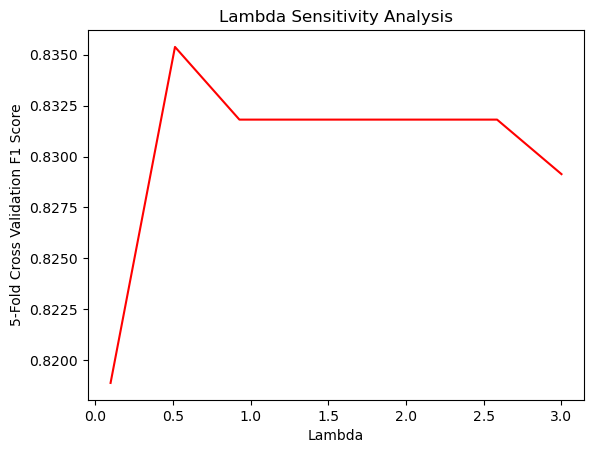

In [85]:
sns.lineplot(x=penalties, y=scores, c="red")
plt.title("Lambda Sensitivity Analysis")
plt.xlabel("Lambda")
plt.ylabel("5-Fold Cross Validation F1 Score");

Clearly, $\lambda=0.5$ is the best hyperparameter configuration. We use this configuration throughout the rest of the notebook.

# Evaluating the Model

Next, we fit several versions of the model using different numbers of input features and compare model performances.

### n=2

The n=2 case is particularly interesting since we can easily visualize the data and optimal decision boundary in two dimensions.

In [95]:
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["radius_mean", "texture_mean"])
# Fit SVM to the training data
w, b, constraints = fit(train, 0.5)
print(w)
print(b)

[1.94763607 0.55550585]
[-0.43240969]


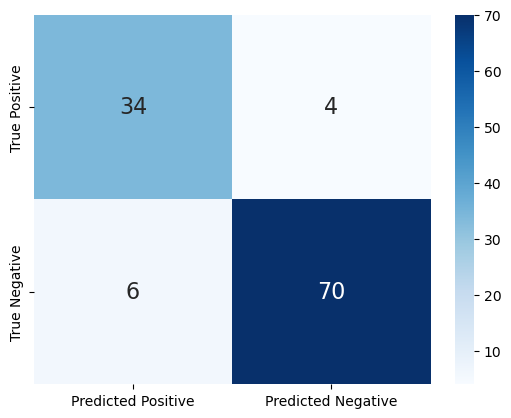

In [87]:
# Display confusion matrix
preds = confusionMatrix(test, w, b)
sns.heatmap(preds, annot=True, cmap='Blues', annot_kws={'size': 16});

In [88]:
# Display the performance metrics (accuracy, precision, recall, f1 score)
metrics(preds)

(0.9122807017543859, 0.8947368421052632, 0.85, 0.8717948717948718)

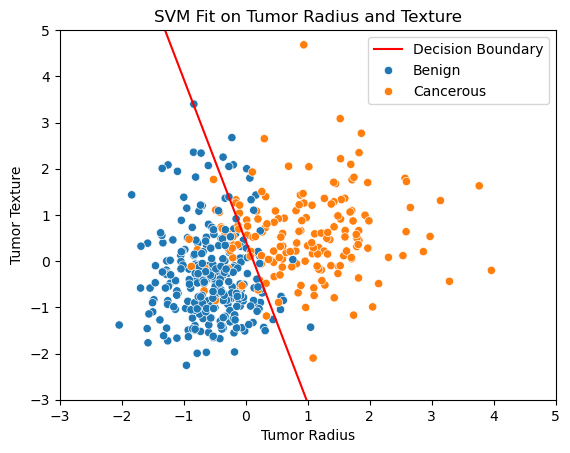

In [89]:
# Plot the decision boundary line
x0, y0 = (0, -b[0])
nx, ny = w
slope = -nx / ny
intercept = (nx * x0 + ny * y0) / ny
x = np.linspace(-10, 10, 100)
y = slope * x + intercept
sns.lineplot(x=x, y=y, label="Decision Boundary", color="red")

# Plot the training data points
x1 = train['radius_mean']
x2 = train['texture_mean']
y = train['diagnosis']
colors = ['Benign' if label == -1 else 'Cancerous' for label in y]
sns.scatterplot(x=x1, y=x2, hue=colors)

plt.xlim(-3, 5)
plt.ylim(-3, 5)
plt.legend(loc="upper right")
plt.title("SVM Fit on Tumor Radius and Texture")
plt.xlabel("Tumor Radius")
plt.ylabel("Tumor Texture");

### n=3

In [96]:
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["radius_mean", "texture_mean", "symmetry_mean"])
w, b, constraints = fit(train, 0.5)
preds = confusionMatrix(test, w, b)
print(w)
print(b)
print(metrics(preds))

[1.98024363 0.56246379 0.83544226]
[-0.45887971]
(0.9385964912280702, 1.0, 0.825, 0.9041095890410958)


### n=4

In [97]:
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["radius_mean", "texture_mean", "symmetry_mean", "concavity_mean"])
w, b, constraints = fit(train, 0.5)
preds = confusionMatrix(test, w, b)
print(w)
print(b)
print(metrics(preds))

[1.69992062 0.51152224 0.37192317 0.87082254]
[-0.36257638]
(0.9473684210526315, 0.9722222222222222, 0.875, 0.9210526315789473)


### n=5

In [98]:
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["radius_mean", "texture_mean", "symmetry_mean", "concavity_mean", "perimeter_mean"])
w, b, constraints = fit(train, 0.5)
preds = confusionMatrix(test, w, b)
print(w)
print(b)
print(metrics(preds))

[0.96205162 0.56831678 0.45230923 0.76731322 0.98774763]
[-0.39782063]
(0.9298245614035088, 0.9705882352941176, 0.825, 0.8918918918918919)


### n=1

In [99]:
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["area_mean"])
w, b, constraints = fit(train, 0.5)
preds = confusionMatrix(test, w, b)
print(w)
print(b)
print(metrics(preds))

[1.93145023]
[-0.3464203]
(0.8859649122807017, 0.9354838709677419, 0.725, 0.8169014084507041)


# Post-Optimality Analysis

In [120]:
from math import log10

In [249]:
data = pd.read_csv(path.join("data", "breast-cancer.csv"))
train, test = prepData(data, features=["radius_mean", "texture_mean"])
w, b, constraints = fit(train, 0.5)

In [253]:
shadowPrices = []
for i in range(len(train)):
    shadowPrices.append(log10(constraints[i].dual_value[0]))

In [254]:
# Apply sigmoid transformation
scale = 2
mid_point = np.median(shadowPrices)
sigmoid_transformed = 1 / (1 + np.exp(-scale * (shadowPrices - mid_point)))
amplified = sigmoid_transformed ** 0.5

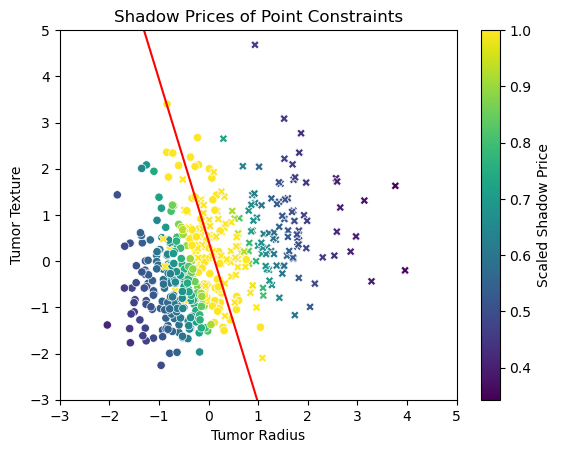

In [271]:
train["shadowPriceLog10"] = amplified
x0, y0 = (0, -b[0])
nx, ny = w
slope = -nx / ny
intercept = (nx * x0 + ny * y0) / ny
x = np.linspace(-10, 10, 100)
y = slope * x + intercept

fig, ax = plt.subplots()

sns.lineplot(x=x, y=y, color="red", legend=False)

sns.scatterplot(
    x="radius_mean",
    y="texture_mean",
    data=train,
    hue="shadowPriceLog10",
    style="diagnosis",
    palette="viridis",
    legend=False
)

# Create a color bar
norm = plt.Normalize(train['shadowPriceLog10'].min(), train['shadowPriceLog10'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Scaled Shadow Price')

plt.xlim(-3, 5)
plt.ylim(-3, 5)
plt.title("Shadow Prices of Point Constraints")
plt.xlabel("Tumor Radius")
plt.ylabel("Tumor Texture");